In [1]:
!rm -rf TileSpGEMM
!git clone https://github.com/SuperScientificSoftwareLaboratory/TileSpGEMM.git
%cd TileSpGEMM

Cloning into 'TileSpGEMM'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 237 (delta 1), reused 0 (delta 0), pack-reused 229 (from 3)
Receiving objects: 100% (237/237), 727.96 KiB | 5.60 MiB/s, done.
Resolving deltas: 100% (75/75), done.
/content/TileSpGEMM


In [2]:
!mkdir -p data
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/Sparse Matrices" data/

Mounted at /content/drive


In [3]:
%cd src

/content/TileSpGEMM/src


In [4]:
# Check current Makefile content
!cat Makefile | grep -A2 -B2 "NVCC_FLAGS"

# Manually set the correct flags as Yuyao specified, plus keep our compatibility flags
!sed -i 's/NVCC_FLAGS = .*/NVCC_FLAGS = -O3 -w -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -arch=compute_61 -code=sm_80 -gencode=arch=compute_61,code=sm_80/' Makefile

# Also fix the CUDA path back to the working one
!sed -i 's|/usr/local/cuda-11.4|/usr/local/cuda|g' Makefile

# Verify both changes
!grep "NVCC_FLAGS" Makefile
!grep "CUDA_INSTALL_PATH" Makefile

# Clean rebuild
!rm -f test
!make
!./test -d 0 -aat 0 ../data/1138_bus.mtx


#CUDA_PARAMETERS
NVCC_FLAGS = -O3 -w -arch=compute_61 -code=sm_86 -gencode=arch=compute_61,code=sm_86
#-gencode=arch=compute_61,code=sm_75
# -m64 -Xptxas -dlcm=cg -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_61,code=compute_61
--

make:
	$(CC) $(NVCC_FLAGS) -Xcompiler -fopenmp -Xcompiler -mfma main.cu -o test $(INCLUDES) $(LIBS) $(OPTIONS) -D VALUE_TYPE=$(VALUE_TYPE)
NVCC_FLAGS = -O3 -w -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -arch=compute_61 -code=sm_80 -gencode=arch=compute_61,code=sm_80
	$(CC) $(NVCC_FLAGS) -Xcompiler -fopenmp -Xcompiler -mfma main.cu -o test $(INCLUDES) $(LIBS) $(OPTIONS) -D VALUE_TYPE=$(VALUE_TYPE)
CUDA_INSTALL_PATH = /usr/local/cuda
INCLUDES = -I$(CUDA_INSTALL_PATH)/include
CUDA_LIBS = -L$(CUDA_INSTALL_PATH)/lib64  -lcudart  -lcusparse
nvcc -O3 -w -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -arch=compute_61 -code=sm_80 -gencode=arch=compute_61,c

In [6]:
import os
import subprocess
import glob
import re

# Find all .mtx files
mtx_files = glob.glob("../data/Sparse Matrices/**/*.mtx", recursive=True)
print(f"Found {len(mtx_files)} files\n")

for i, mtx_file in enumerate(mtx_files):
    folder_name = os.path.basename(os.path.dirname(mtx_file))
    file_name = os.path.basename(mtx_file)

    print(f"[{i+1}/12] {folder_name}/{file_name}")

    cmd = ["./test", "-d", "0", "-aat", "0", mtx_file]
    result = subprocess.run(cmd, capture_output=True, text=True, timeout=60)

    if result.returncode == 0:
        print(result.stdout)
    else:
        print(f"Execution failed (exit code: {result.returncode})")
        if result.stderr:
            print(f"STDERR: {result.stderr}")

Found 12 files

[1/12] cant/cant.mtx
--------------------------------!!!!!!!!------------------------------------
device_id = 0
---------------------------------------------------------------
Device [ 0 ] NVIDIA A100-SXM4-40GB @ 1410.00 MHz
MAT: -------------- ../data/Sparse Matrices/cant/cant.mtx --------------
input matrix A: ( 62451, 62451 ) nnz = 4007383
 loadfile time    = 1.06993 sec
the tilesize = 16
SpGEMM nnzCub = 269486473
CSR to Tile conversion uses 21.59 ms
tile space overhead = 37.74 MB
step1 ----Calculate the number and tile-column index of tiles of matrixC---
step1 ---------------------- Runtime is  1.50 ms-------------------------

step2 --------Calculate the number of nonzeros of each tile of matrixC-----
step2 ---------------------- Runtime is  1.13 ms-------------------------

step3 ---------Calculate the val&col of nonzeros of matrixC-------------
step3 ---------------------- Runtime is  6.75 ms------------------------

-----------------------Malloc uses 0.80 ms----

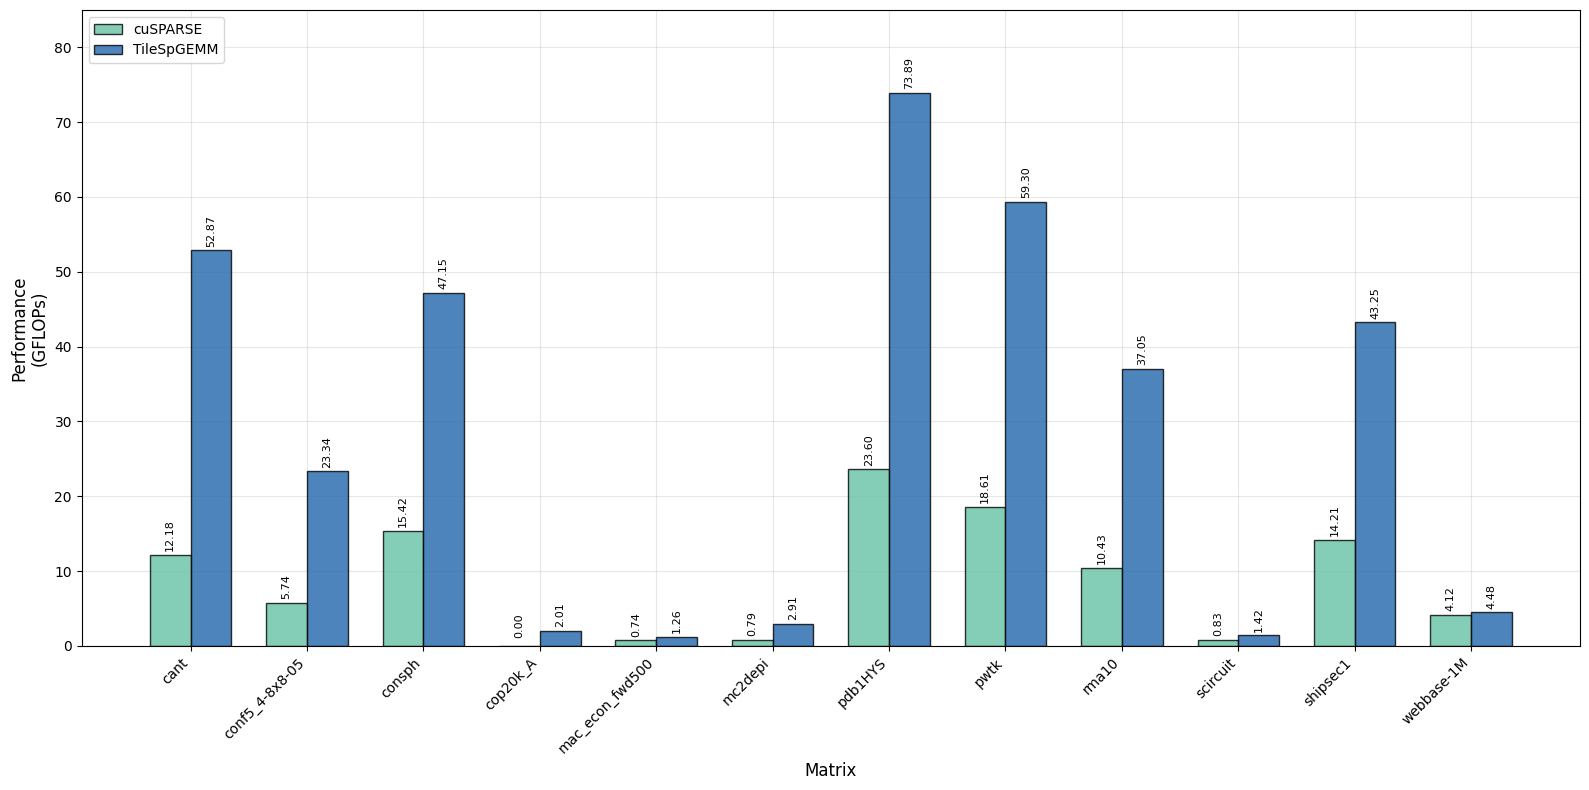

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Performance data in GFLOPs
matrices = ['cant', 'conf5_4-8x8-05', 'consph', 'cop20k_A', 'mac_econ_fwd500',
           'mc2depi', 'pdb1HYS', 'pwtk', 'rma10', 'scircuit',
           'shipsec1', 'webbase-1M']
cusparse_gflops = [12.18, 5.74, 15.42, 0, 0.74, 0.79, 23.60, 18.61, 10.43, 0.83, 14.21, 4.12]
tilespgemm_gflops = [52.87, 23.34, 47.15, 2.01, 1.26, 2.91, 73.89, 59.30, 37.05, 1.42, 43.25, 4.48]


fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.35
x_pos = np.arange(len(matrices))

# Create bars
bars1 = ax.bar(x_pos - bar_width/2, cusparse_gflops, bar_width,
               label='cuSPARSE', color='#66c2a5', alpha=0.8,
               edgecolor='black', linewidth=1)
bars2 = ax.bar(x_pos + bar_width/2, tilespgemm_gflops, bar_width,
               label='TileSpGEMM', color='#2166ac', alpha=0.8,
               edgecolor='black', linewidth=1)

# Add value labels on top of bars
def add_value_labels(bars, values):
    for i, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        if value == 0:
            ax.text(bar.get_x() + bar.get_width()/2., 1.0,
                   '0.00',
                   ha='center', va='bottom', fontsize=8, rotation=90)
        elif height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{value:.2f}',
                   ha='center', va='bottom', fontsize=8, rotation=90)

add_value_labels(bars1, cusparse_gflops)
add_value_labels(bars2, tilespgemm_gflops)

ax.set_xlabel('Matrix', fontsize=12)
ax.set_ylabel('Performance\n(GFLOPs)', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(matrices, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, which='both')
ax.set_axisbelow(True)
ax.set_ylim(0, max(max(cusparse_gflops), max(tilespgemm_gflops)) * 1.15)

plt.tight_layout()
plt.show()